In [1]:
import bempp.api
import numpy as np

In [2]:
#bempp.api.set_ipython_notebook_viewer()
#bempp.api.PLOT_BACKEND = "ipython_notebook"

In [3]:
k = 6.
h = 0.1
grid = bempp.api.shapes.sphere(h=h)
p1 = bempp.api.function_space(grid, "P", 1) #bempp.api.function_space(grid, "B-P", 1)
dual0 = bempp.api.function_space(grid, "P", 1) #bempp.api.function_space(grid, "DUAL", 0)
print("P1 space dofs: {0}".format(p1.global_dof_count))
print("Dual space dofs: {0}".format(dual0.global_dof_count))

P1 space dofs: 1605
Dual space dofs: 1605


In [4]:
hmax = 0
for element in  list(grid.leaf_view.entity_iterator(0)):
    hmax = max(hmax,element.geometry.volume)
        
########################################################################
epsilon = 300.0
alpha = 1.0
beta_D = alpha/hmax
beta_N = alpha*hmax
beta = (epsilon/beta_N + beta_D)/(epsilon + 1.0)    
    
multi = bempp.api.BlockedOperator(2,2)
multi[0,0] = -bempp.api.operators.boundary.helmholtz.double_layer(p1, p1, dual0, k)
multi[0,1] =  bempp.api.operators.boundary.helmholtz.single_layer(dual0, p1, dual0, k)
multi[1,0] =  bempp.api.operators.boundary.helmholtz.hypersingular(p1, dual0, p1, k)
multi[1,1] =  bempp.api.operators.boundary.helmholtz.adjoint_double_layer(dual0, dual0, p1, k)

diri = bempp.api.BlockedOperator(2,2)
diri[0,0] = -0.5 * ((epsilon*beta-1.0)/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(p1, p1, dual0)
diri[0,1] =  (epsilon/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(dual0, p1, dual0)
diri[1,0] =  (beta/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(p1, dual0, p1)
diri[1,1] =  0.5 * ((epsilon*beta-1.0)/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(dual0, dual0, p1)

In [5]:
def f(x, n, domain_ind, res):
    res[0] = np.exp(1j * k * np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2))/np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2)
        
f_fun = bempp.api.GridFunction(p1, fun=f)

def g(x, n, d, res):
    grad = np.array([
        (x[0]-2)*(1j * k * np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2) - 1)*np.exp(1j * k * np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2))/(((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2)**(3.0/2.0)),
        (x[1]-2)*(1j * k * np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2) - 1)*np.exp(1j * k * np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2))/(((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2)**(3.0/2.0)),
        (x[2]-2)*(1j * k * np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2) - 1)*np.exp(1j * k * np.sqrt((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2))/(((x[0]-2)**2+(x[1]-2)**2+(x[2]-2)**2)**(3.0/2.0))
        ])
    res[0] = np.dot(grad, n)

g_fun = bempp.api.GridFunction(dual0, fun=g)

rhs = [diri[0,1]*(1.0/epsilon*f_fun+g_fun), diri[1,0]*(f_fun+epsilon*g_fun)]

In [6]:
sol, info, it_count = bempp.api.linalg.gmres(multi+diri, rhs, tol = 1e-8, return_iteration_count=True, use_strong_form=True)
print("Solution took",it_count,"iterations")

('Solution took', 98, 'iterations')


In [7]:
e_fun = [sol[0]-f_fun,sol[1]-g_fun]

error = 0
# V norm
slp = bempp.api.operators.boundary.helmholtz.single_layer(dual0, p1, dual0, k)
hyp = bempp.api.operators.boundary.helmholtz.hypersingular(p1, dual0, p1, k)
error += np.sqrt(np.dot(e_fun[1].coefficients.conjugate(),(slp * e_fun[1]).projections(dual0)))
error += np.sqrt(np.dot(e_fun[0].coefficients.conjugate(),(hyp * e_fun[0]).projections(p1)))
# R part
error += (epsilon/(epsilon*beta+1.0))**.5 * e_fun[0].l2_norm()
error += (beta/(epsilon*beta+1.0))**.5 * e_fun[1].l2_norm()

print("Error:",error)

('Error:', (0.0095634087000257759-0.0035466596692841669j))


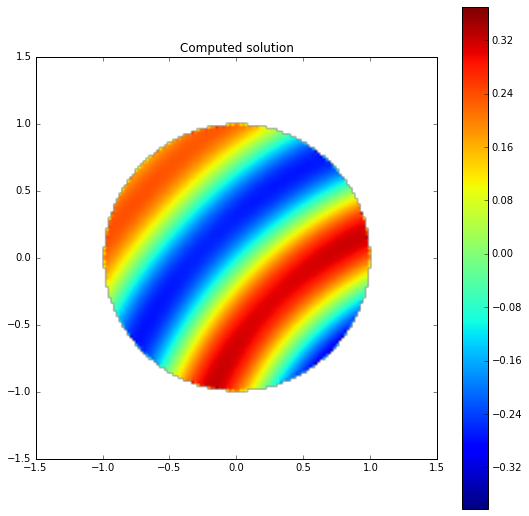

In [8]:
n_grid_points = 150
plot_grid = np.mgrid[-1.5:1.5:n_grid_points*1j, -1.5:1.5:n_grid_points*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))
slp_pot = bempp.api.operators.potential.helmholtz.single_layer(dual0, points, k)
dlp_pot = bempp.api.operators.potential.helmholtz.double_layer(p1, points, k)
# identity_pot = bempp.api.operators.potential.identity(bempp_space, points)


dirichlet_fun = bempp.api.GridFunction(p1, fun=f)
neumann_fun = bempp.api.GridFunction(dual0, fun=g)

u_evaluated =  slp_pot * sol[1] - dlp_pot * sol[0]
# u_evaluated =  slp_pot * neumann_fun - dlp_pot * dirichlet_fun

# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

# Filter out solution values that are associated with points outside the unit circle.
u_evaluated = u_evaluated.reshape((n_grid_points,n_grid_points))
radius = np.sqrt(plot_grid[0]**2 + plot_grid[1]**2)
u_evaluated[radius>1] = np.nan

# Plot the image
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9.0, 9.0)

from matplotlib import pylab as plt

plt.imshow(np.real(u_evaluated.T), extent=(-1.5,1.5,-1.5,1.5))
plt.title('Computed solution')
plt.colorbar()